In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [4]:
# Load the data
data = pd.read_csv('../datasets/NVDA.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# Remove any rows with NaN values
data.dropna(inplace=True)
data.head(500)

         Date   Open     High    Low  Close    Volume
0  2010-01-04  18.51  18.6200  18.11  18.49  20005100
1  2010-01-05  18.51  18.9600  18.42  18.76  18216200
2  2010-01-06  18.75  18.9200  18.57  18.88  16229200
3  2010-01-07  18.78  18.8600  18.37  18.51  13694800
4  2010-01-08  18.36  18.6821  18.25  18.55  11954200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2010-03-16,17.15,17.86,17.14,17.755,16624700,17.389,17.1875,16.93125,17.0574,17.393401,17.228277,17.063097,17.180483,65.751634
50,2010-03-17,17.86,18.34,17.86,18.100,16279200,17.491,17.3345,16.94425,17.0496,17.628934,17.386772,17.161850,17.216543,71.144279
51,2010-03-18,18.13,18.13,17.30,17.460,18524100,17.545,17.4145,16.98375,17.0236,17.572623,17.400087,17.190245,17.226090,64.125561
52,2010-03-19,17.72,17.77,17.03,17.250,14615300,17.545,17.4225,17.01725,16.9910,17.465082,17.372798,17.195936,17.227028,54.975124
53,2010-03-22,17.03,17.60,17.03,17.530,10883400,17.619,17.4835,17.06325,16.9714,17.486721,17.401380,17.227752,17.238909,58.041958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2012-03-01,15.21,15.43,15.15,15.250,11248600,15.398,15.6945,15.83750,14.8944,15.388932,15.560213,15.553745,15.181346,31.448763
545,2012-03-02,15.20,15.60,15.20,15.380,17101900,15.316,15.5875,15.83225,14.9389,15.385954,15.527447,15.537198,15.189136,39.921722
546,2012-03-05,15.27,15.30,14.75,14.860,12871200,15.194,15.4885,15.78425,14.9581,15.210636,15.406093,15.472703,15.176229,27.127660
547,2012-03-06,14.69,14.81,14.46,14.720,11785000,15.072,15.3680,15.73550,14.9781,15.047091,15.281349,15.401017,15.158337,23.519164


In [5]:
feature_columns = [
    'Close',          
    'Low',            
    'High',          
    'Open',           
    'EMA for 5 days', 
    'MA for 5 days',  
    'RSI_14'   
]    

features = data[feature_columns].values

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 15  # 60-day window
X, y = create_sequences(scaled_data, seq_length)

# Split 80/20 chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(np.isnan(X_train).any(), np.isnan(y_train).any())
print(np.isinf(X_train).any(), np.isinf(y_train).any())

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

False False
False False
Training samples: 2163, Testing samples: 541
X_train shape: (2163, 15, 7), y_train shape: (2163,)


In [6]:
# Load the saved model
model = tf.keras.models.load_model('gru_lstm_model.keras')

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
# Create dummy arrays to match the number of features for inverse scaling
y_pred_scaled = np.zeros((len(y_pred), len(feature_columns)))
y_pred_scaled[:, 0] = y_pred[:, 0]  # Place predictions in 'Close' column
y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]  # Extract 'Close'

y_test_scaled = np.zeros((len(y_test), len(feature_columns)))
y_test_scaled[:, 0] = y_test  # Place actual values in 'Close' column
y_test = scaler.inverse_transform(y_test_scaled)[:, 0]  # Extract 'Close'

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


RMSE: 14.94
MAE: 10.37
R^2: 0.99
MAPE: 4.13%


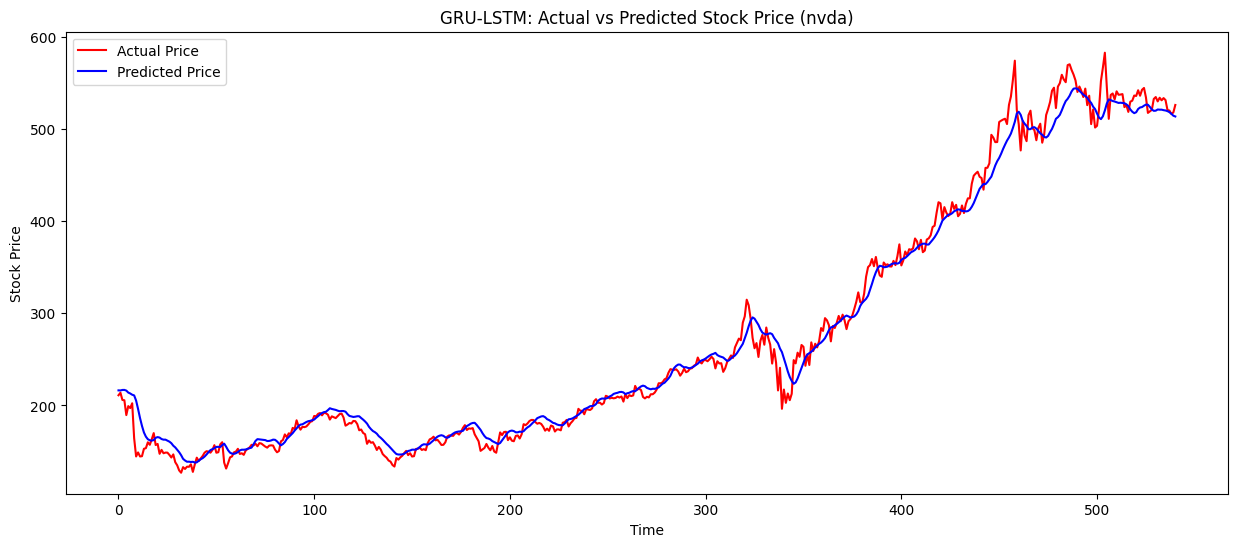

In [8]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R^2: {r2:.2f}')
print(f'MAPE: {mape:.2f}%')

# Plot actual vs predicted prices
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Price', color='red')
plt.plot(y_pred, label='Predicted Price', color='blue')
plt.title('GRU-LSTM: Actual vs Predicted Stock Price (nvda)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

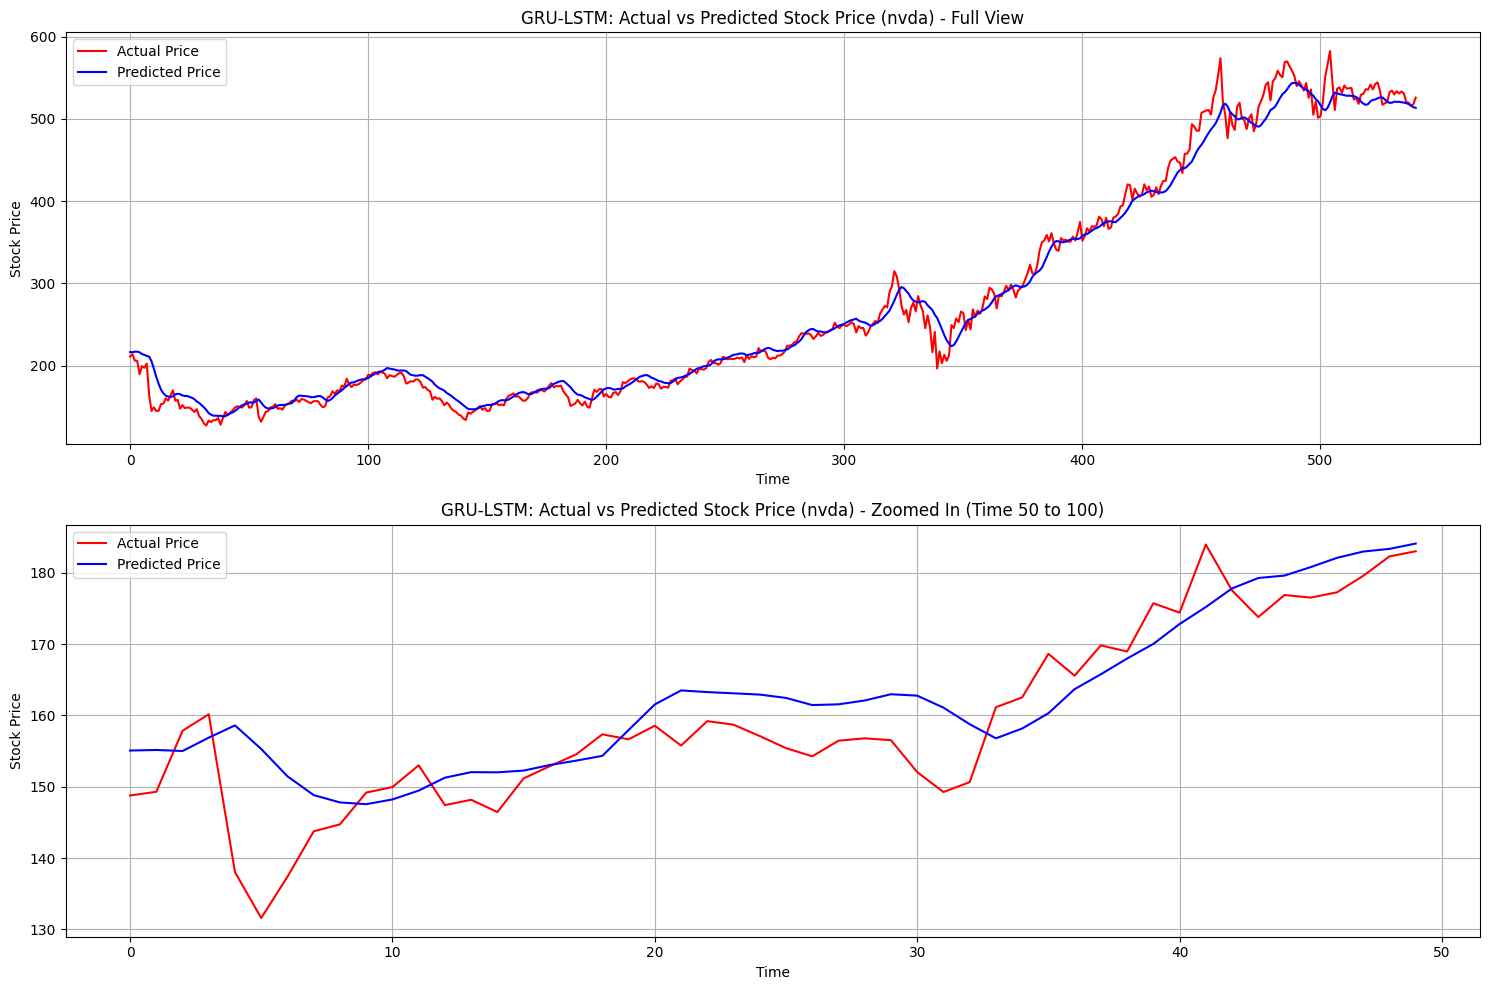

In [9]:
def plot_predictions_with_zoom(test_label, predicted, title="Actual vs Predicted Stock Price", zoom_start=50, zoom_end=100):
    plt.figure(figsize=(15, 10))

    # Full plot
    plt.subplot(2, 1, 1)
    plt.plot(test_label, label='Actual Price', color='red')
    plt.plot(predicted, label='Predicted Price', color='blue')
    plt.title(f"{title} - Full View")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    # Zoomed-in plot to highlight short-term fluctuations
    plt.subplot(2, 1, 2)
    plt.plot(test_label[zoom_start:zoom_end], label='Actual Price', color='red')
    plt.plot(predicted[zoom_start:zoom_end], label='Predicted Price', color='blue')
    plt.title(f"{title} - Zoomed In (Time {zoom_start} to {zoom_end})")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_predictions_with_zoom(y_test, y_pred, title="GRU-LSTM: Actual vs Predicted Stock Price (nvda)", zoom_start=50, zoom_end=100)